#### Imports...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn import datasets
#from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
#from bioinfokit.analys import get_data
#from bioinfokit.visuz import cluster
import warnings
warnings.filterwarnings("ignore")


In [2]:
df= pd.read_csv (r'../europe.csv')
df.head(3)

,Country,Area,GDP,Inflation,Life.expect,Military,Pop.growth,Unemployment
0,Austria,83871,41600,3.5,79.91,0.8,0.03,4.2
1,Belgium,30528,37800,3.5,79.65,1.3,0.06,7.2
2,Bulgaria,110879,13800,4.2,73.84,2.6,-0.80,9.6


In [3]:
#Estandarizo los datos
df_countries= df["Country"]
df_stand=  StandardScaler().fit_transform(df[["Area", "GDP", "Inflation", "Life.expect", "Military", "Pop.growth", "Unemployment"]])
df_stand= pd.DataFrame(df_stand, columns=df[["Area", "GDP", "Inflation", "Life.expect", "Military", "Pop.growth", "Unemployment"]].columns)
df_stand.head(3)

,Area,GDP,Inflation,Life.expect,Military,Pop.growth,Unemployment
0,-0.507835,0.683900,0.114447,0.570778,-1.024347,-0.176789,-1.245527
1,-0.835987,0.417061,0.114447,0.487756,-0.388952,-0.115927,-0.592442
2,-0.341689,-1.268238,0.624255,-1.367473,1.263074,-1.860631,-0.069973


### Variables

In [146]:
k = 3
n = 7
radius = 100
learning_rate = 0.7

In [8]:
#example
weights = [[i+j*k for i in range(k)] for j in range(k)]
#starts weights with values from 0 to k*k, like this:
#[[0, 1, 2],
# [3, 4, 5],
# [6, 7, 8]]

weights

[[0, 1, 2], [3, 4, 5], [6, 7, 8]]

```reloading our functions...```

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2


what are neighbors?

In [46]:
from utils import get_avg_distance, get_neighbors_avg_dst, get_neighbors
test_mat = [ [[0, 0],[0,1],[0,2],[0,3]],[[1,0],[1,1],[1,2],[1,3]],[[2,0],[2,1],[2,2],[2,3]], [[3,0],[3,1],[3,2],[3,3]]]
for i in range(4):
    for j in range(4):
        print(test_mat[i][j], end=" ")
    print('\n')

print(get_neighbors(test_mat, 1,1))
print(get_neighbors_avg_dst(1,1, test_mat))
print(get_avg_distance(test_mat))

[0, 0] [0, 1] [0, 2] [0, 3] 

[1, 0] [1, 1] [1, 2] [1, 3] 

[2, 0] [2, 1] [2, 2] [2, 3] 

[3, 0] [3, 1] [3, 2] [3, 3] 

[(0, 1), (2, 1), (1, 0), (1, 2)]
1.0
1.0


### `the loop`

<IPython.core.display.Javascript object>


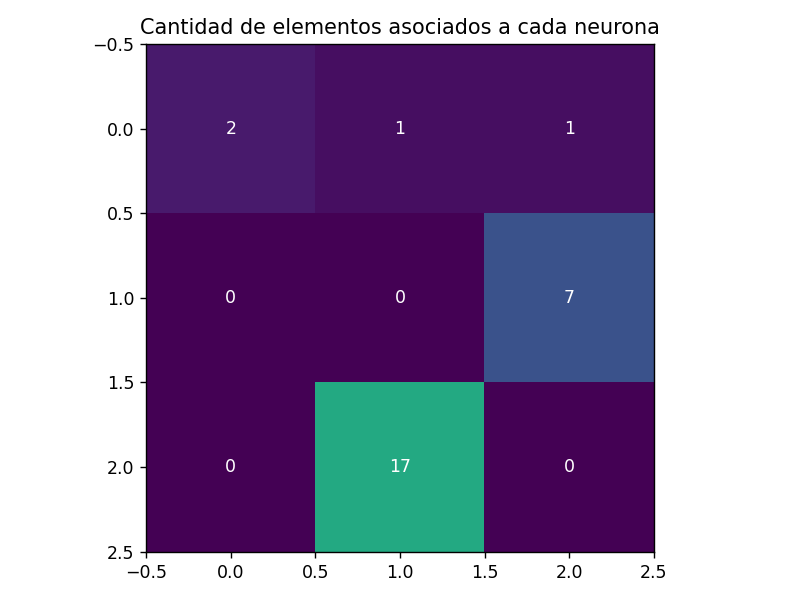

Distancia promedio entre neuronas vecinas (iter final): 0.13628612308327334
[[2, 1, 1], [0, 0, 7], [0, 17, 0]]
100
1.0 0.0 100 0.7


In [158]:
from utils import init_weights, init_weights_from_data, get_winner_neuron, get_active_neurons, update_weights, get_avg_distance
import matplotlib.pyplot as plt

epochs = 100
data_count = len(df_stand.index)
max_t = epochs * data_count
t = 0

w = init_weights_from_data(k, n, df_stand, data_count)


#plotting array
points = np.array([[0 for i in range(k)] for j in range(k)])

free_points = []

#vars
lr = learning_rate
r = radius


for e in range(epochs):
    points = [[0 for i in range(k)] for j in range(k)]
    
    for p in range(data_count):
        #get sample from data
        x_p = df_stand.iloc[[p]][["Area", "GDP", "Inflation", "Life.expect", "Military", "Pop.growth", "Unemployment"]].to_numpy()

        #find winner neuron
        closest_info = get_winner_neuron(w, x_p, k)

        points[closest_info['x']][ closest_info['y']] += 1

        #neuronas activadas
        N_k = get_active_neurons(w, k, closest_info['x'], closest_info['y'], r)

        #actualizar pesos
        w = update_weights(w, x_p, N_k, lr)

        #update radius and learning_rate
        r = np.floor((max_t - t*1.2) * r/max_t) + 1
        lr = lr/(t+1)
        t += 1
    
    free_points.append(points)

#plotting the final heatmap...
fig1, ax = plt.subplots()
im = ax.imshow(points, vmin=0, vmax=28)
# Loop over data dimensions and create text annotations.
for i in range(k):
    for j in range(k):
        if points[i][j] <= 20: 
            text = ax.text(j, i, points[i][j], ha="center", va="center", color="w")
        else:
            text = ax.text(j, i, points[i][j], ha="center", va="center", color="b")

ax.set_title("Cantidad de elementos asociados a cada neurona")
fig1.tight_layout()
plt.show()


#calculate avg neighbors distance for final iter...
print("Distancia promedio entre neuronas vecinas (iter final):", get_avg_distance(w))
print(points)
print(len(free_points))
print(r, lr, radius, learning_rate)


### code refactor!

In [6]:
from som import Params, SOM

params = Params(k=3,n=7,r=10, lr=0.7)
som = SOM(params, data=df_stand, epochs=100)
res = som.run()

print(len(res['heatmaps']))
print(res['averages'][len(res['averages']) - 1])
#print(res['heatmaps'][len(res['heatmaps']) - 1])
#for i in range(len(res['heatmaps'])):
    #print(res['heatmaps'][i])



100
[[1.5170293399577708, 1.191890318371535, 1.0613597985339867], [1.5663124366807624, 1.4585932202910263, 0.9239910864029467], [1.0807411204863298, 1.6903489618078578, 1.4824975053345129]]


### trying to show an animation in jupyter notebook (not in VSCode)

#### required for animations

In [7]:
%matplotlib notebook

#### heatmap animation (doesn't work in VSCode at least...)

<IPython.core.display.Javascript object>


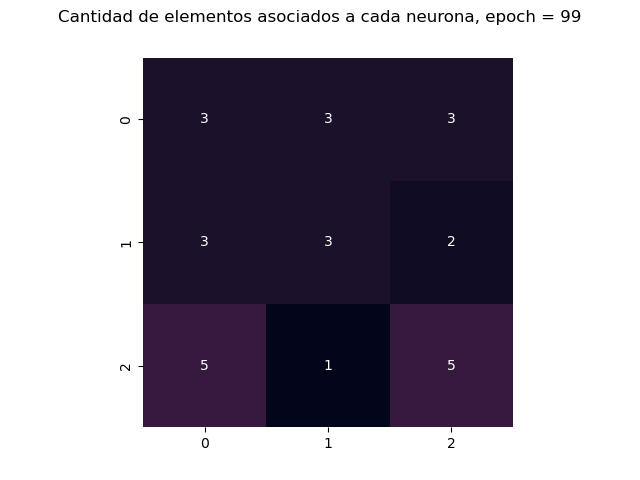

we are done here


In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation

fig2 = plt.figure()
fig2.tight_layout()

my_heats = res['heatmaps']
#my_heats = free_points

#data = np.random.rand(10, 10)
#sns.heatmap(data, vmax=.8, square=True)
#labels = (np.asarray(["{1:.3f}".format(value) for value in my_heats[0]])).reshape(params.k, params.k)
labels= my_heats[0]
#sns.heatmap(my_heats[0], annot=labels)
sns.heatmap(my_heats[0])

def init():
    #sns.heatmap(np.zeros((10, 10)), vmax=.8, square=True, cbar=False)
    #labels= my_heats[0]
    #sns.heatmap(my_heats[0], annot=labels, vmax=28, square=True, cbar=False)
    sns.heatmap(my_heats[0], vmax=28, square=True, cbar=False)

def animate(i):
    #data = np.random.rand(10, 10)
    frame_data = my_heats[i]
    print(str(i))
    #sns.heatmap(data, vmax=.8, square=True, cbar=False)
    #labels = (np.asarray(["{1:.3f}".format( value) for value in frame_data])).reshape(params.k, params.k)
    plt.clf()
    fig2.suptitle("Cantidad de elementos asociados a cada neurona, epoch = " + str(i))
    #CURRENT ISSUE: labels don't get cleaned on draw()/animate(), so they step over each other on every redraw
    labels = frame_data
    sns.heatmap(frame_data, annot=True, vmax=28, square=True, cbar=False)

#anim = animation.FuncAnimation(fig, animate, init_func=init, frames=20, repeat = False)
anim = animation.FuncAnimation(fig2, animate, init_func=init, frames=len(my_heats), interval = 200, repeat = False)

print('we are done here')
#anim.save("TEST.gif", dpi=300, writer= animation.PillowWriter(fps=5))

#### Donde caemos (los paises)?

In [16]:
som.test(df_countries, res['weights'])

[[['Greece', 'Portugal', 'Spain'],
  ['Finland', 'Italy', 'United Kingdom'],
  ['Germany', 'Norway', 'Sweden']],
 [['Croatia', 'Hungary', 'Poland'],
  ['Czech Republic', 'Ireland', 'Slovenia'],
  ['Netherlands', 'Switzerland']],
 [['Bulgaria', 'Estonia', 'Latvia', 'Lithuania', 'Ukraine'],
  ['Slovakia'],
  ['Austria', 'Belgium', 'Denmark', 'Iceland', 'Luxembourg']]]

#### average distances


<IPython.core.display.Javascript object>


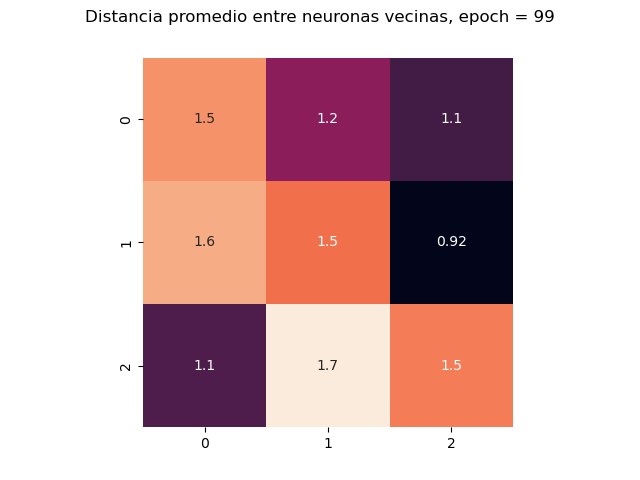

we are done here


In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation

fig4 = plt.figure()
fig4.tight_layout()

my_avgs = res['averages']
#my_heats = free_points

#data = np.random.rand(10, 10)
#sns.heatmap(data, vmax=.8, square=True)
#labels = (np.asarray(["{1:.3f}".format(value) for value in my_heats[0]])).reshape(params.k, params.k)
labels= my_avgs[0]
#sns.heatmap(my_heats[0], annot=labels)
sns.heatmap(my_avgs[0])

def init():
    #sns.heatmap(np.zeros((10, 10)), vmax=.8, square=True, cbar=False)
    #labels= my_heats[0]
    #sns.heatmap(my_heats[0], annot=labels, vmax=28, square=True, cbar=False)
    sns.heatmap(my_avgs[0], vmax=max(map(max, my_avgs[0])), square=True, cbar=False)

def animate(i):
    #data = np.random.rand(10, 10)
    frame_data = my_avgs[i]
    #print(str(i))
    #sns.heatmap(data, vmax=.8, square=True, cbar=False)
    #labels = (np.asarray(["{1:.3f}".format( value) for value in frame_data])).reshape(params.k, params.k)
    plt.clf()
    fig4.suptitle("Distancia promedio entre neuronas vecinas, epoch = " + str(i))
    #CURRENT ISSUE: labels don't get cleaned on draw()/animate(), so they step over each other on every redraw
    labels = frame_data
    sns.heatmap(frame_data, annot=True, vmax=max(map(max, frame_data)), square=True, cbar=False)

#anim = animation.FuncAnimation(fig, animate, init_func=init, frames=20, repeat = False)
anim = animation.FuncAnimation(fig4, animate, init_func=init, frames=len(my_avgs), interval = 200, repeat = False)

print('we are done here')